Business problem:

Causal inference, I want to give the client a basic understanding of how the variables affect each other.

Quantitave estimates of causal effects 

hypothesis: That the there is a correlation between the predictors and the target 

why important? decreases the changes that your analysis is totally wrong. 

Can I give a clear answer with the data I have? Say we cannot give a proper estimate? 

Possibly missing a variable that is important, such as seasonality? and that the prices change too much??

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from feature_engine.encoding import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

In [3]:
# First look at the dataframe
listing = pd.read_csv('Data/new_orleans_airbnb_listings.csv')
listing.head(1)

,id,name,description,neighborhood_overview,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,reviews_per_month
0,19091,Fully Furnished Cozy Apartment,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,"NorthWest Carrollton, where this apartment is ...",72880,2010-01-23,"New Orleans, Louisiana, United States",within an hour,100%,100%,...,4.89,4.95,4.88,4.97,4.97,4.67,4.91,"17STR-08877, 20-OSTR-0105",t,5.07


In [4]:
listing.isnull().sum()

id                                0
name                              0
description                      28
neighborhood_overview          1414
host_id                           0
host_since                       38
host_location                    45
host_response_time             1579
host_response_rate             1579
host_acceptance_rate           1466
host_is_superhost                38
host_listings_count              38
host_verifications                0
host_has_profile_pic             38
host_neighbourhood              670
host_identity_verified           38
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms_text                   16
bedrooms                        303
beds                            122
amenities                         0
price                             0
minimum_nights              

In [5]:
listing['review_scores_cleanliness'].value_counts().head(5)

5.00    1133
4.94     153
4.97     150
4.92     147
4.93     142
Name: review_scores_cleanliness, dtype: int64

In [6]:
# example of neighborhood overview
listing['neighborhood_overview'].loc[2]

'Ours is a neighborhood made up of artists, musicians and plain old working class people.  It is a dog centric, friendly place to be.'

`neighborhood_overview` is an optional discripition for host to add to their listing. It is not required and each is uniquily writen by a host. For this reason I am going to remove it.

In [7]:
# example of neighborhood overview
listing['host_response_time'].value_counts()

within an hour        3658
within a few hours     398
within a day           281
a few days or more     112
Name: host_response_time, dtype: int64

In [8]:
# example of neighborhood overview
listing['host_neighbourhood'].value_counts().head(10)

Central Business District    468
Marigny/Bywater              382
Central City                 371
Seventh Ward                 350
Lower Garden District        320
Treme                        259
Edgewater                    239
French Quarter               222
Mid City                     188
Uptown                       167
Name: host_neighbourhood, dtype: int64

In [9]:
irrelevant = ['neighborhood_overview', 'host_since', 'host_location', 'host_response_time', 'host_response_rate',
              'host_acceptance_rate', 'host_verifications', 'host_has_profile_pic', 'host_neighbourhood', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'first_review', 'last_review', 'license', 'host_identity_verified', 'reviews_per_month', 
              'host_listings_count', 'has_availability', 'amenities']
focus = listing.drop(irrelevant, axis=1)

In [10]:
focus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6028 entries, 0 to 6027
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6028 non-null   int64  
 1   name                         6028 non-null   object 
 2   description                  6000 non-null   object 
 3   host_id                      6028 non-null   int64  
 4   host_is_superhost            5990 non-null   object 
 5   neighbourhood_cleansed       6028 non-null   object 
 6   latitude                     6028 non-null   float64
 7   longitude                    6028 non-null   float64
 8   property_type                6028 non-null   object 
 9   room_type                    6028 non-null   object 
 10  accommodates                 6028 non-null   int64  
 11  bathrooms_text               6012 non-null   object 
 12  bedrooms                     5725 non-null   float64
 13  beds              

In [11]:
focus['neighbourhood_cleansed'].value_counts()

Central Business District    840
Central City                 506
Marigny                      387
Treme - Lafitte              387
Seventh Ward                 374
                            ... 
Dixon                          3
New Aurora - English Turn      3
U.S. Naval Base                3
Read Blvd West                 2
B. W. Cooper                   1
Name: neighbourhood_cleansed, Length: 67, dtype: int64

In [12]:
listing['host_neighbourhood'].value_counts()

Central Business District    468
Marigny/Bywater              382
Central City                 371
Seventh Ward                 350
Lower Garden District        320
                            ... 
Inwood                         1
East New York                  1
Long Beach                     1
Lincoln Park                   1
Westshore                      1
Name: host_neighbourhood, Length: 132, dtype: int64

In [13]:
# check for duplicates
focus.duplicated().sum()

0

In [14]:
# search for duplicates
dupes = focus[focus['id'].duplicated()]
len(dupes)

0

#### remove NaN is review columns

In [15]:
# Looks like the mean would be a good option for replacing null values
focus['review_scores_rating'].median()

4.86

In [16]:
# Replace the null values for the review variables with the mean for that variable
focus['review_scores_rating'].fillna((focus['review_scores_rating'].median()), inplace=True)
focus['review_scores_accuracy'].fillna((focus['review_scores_accuracy'].median()), inplace=True)
focus['review_scores_cleanliness'].fillna((focus['review_scores_cleanliness'].median()), inplace=True)
focus['review_scores_checkin'].fillna((focus['review_scores_checkin'].median()), inplace=True)
focus['review_scores_communication'].fillna((focus['review_scores_communication'].median()), inplace=True)
focus['review_scores_location'].fillna((focus['review_scores_location'].median()), inplace=True)
focus['review_scores_value'].fillna((focus['review_scores_value'].median()), inplace=True)

#### remove NaN is `host_is_superhost`

In [17]:
# view value_counts
focus['host_is_superhost'].value_counts()

f    3306
t    2684
Name: host_is_superhost, dtype: int64

In [18]:
# Fill NaN with 'unknown' so it is easier to view & find the missing data
focus['host_is_superhost'].fillna('unknown', inplace=True)

In [19]:
# According to airbnb you need to have an overall rating of 4.8 to be superhost, so searching for those with rating 
# above 4.8 are most likely a superhost
focus.loc[(focus['host_is_superhost'] == 'unknown') & (focus['review_scores_rating'] >= 4.8), 'host_is_superhost'] = 't'

In [20]:
# those with overall rating under 4.8 are most likely not a superhost
focus.loc[(focus['host_is_superhost'] == 'unknown') & (focus['review_scores_rating'] < 4.8), 'host_is_superhost'] = 'f'

In [21]:
# view value_counts now that NaN values have been replaced
focus['host_is_superhost'].value_counts()

f    3312
t    2716
Name: host_is_superhost, dtype: int64

#### remove NaN is `bedrooms`

In [22]:
# See what going on with the missing bedroomd data
focus['bedrooms'].value_counts(normalize=True)

1.0     0.398603
2.0     0.306550
3.0     0.175197
4.0     0.060786
5.0     0.040873
6.0     0.008384
8.0     0.003319
7.0     0.002271
9.0     0.001572
10.0    0.000699
11.0    0.000349
12.0    0.000349
21.0    0.000175
18.0    0.000175
16.0    0.000175
15.0    0.000175
19.0    0.000175
23.0    0.000175
Name: bedrooms, dtype: float64

In [23]:
# Created a new df so I can take a closer look into what would be best to fill the NaN values with
na_bedroom = null_rating = focus[focus['bedrooms'].isnull()]
na_bedroom.head(5)

,id,name,description,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
31,425878,Bayou St. John Cottage!!,<b>The space</b><br />Hello! I have an indepe...,1919429,f,Bayou St. John,29.97465,-90.08823,Entire guesthouse,Entire home/apt,...,246,36,4.69,4.66,4.66,4.94,4.91,4.89,4.77,f
37,461675,Studio condo1 in New Orleans,A direct booking is NOT RECOMMENDED. Please se...,103427,f,Central City,29.93579,-90.07948,Entire rental unit,Entire home/apt,...,359,5,4.60,3.80,5.00,4.80,4.80,4.80,4.40,f
53,708852,studio unit 3 New Orleans,studio unit for up to a party of 4. Can reque...,103427,f,Lower Garden District,29.93396,-90.08066,Entire rental unit,Entire home/apt,...,90,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
63,810413,City Cove: Great Monthly Rates!,Professionally decorated studio apartment cent...,2852373,t,Central City,29.93362,-90.08313,Entire rental unit,Entire home/apt,...,189,47,4.66,4.83,4.36,4.96,4.89,4.91,4.64,f
150,1452644,Charming casita by Mississipi River,Have a relaxing retreat in a private 500 squar...,7793229,t,Holy Cross,29.95697,-90.02314,Entire residential home,Entire home/apt,...,0,233,4.80,4.88,4.94,4.94,4.95,4.60,4.86,t


In [24]:
# check out the property type for rows with no bedroom count
na_bedroom['property_type'].value_counts()

Entire rental unit                  105
Entire guest suite                   29
Entire condominium (condo)           26
Entire guesthouse                    25
Room in boutique hotel               24
Entire residential home              15
Room in hotel                        13
Room in bed and breakfast            10
Entire serviced apartment             9
Private room in rental unit           9
Entire loft                           7
Private room in residential home      6
Private room in guest suite           4
Entire cottage                        3
Room in aparthotel                    3
Tiny house                            2
Private room in guesthouse            2
Entire place                          2
Entire townhouse                      2
Private room in resort                2
Private room in loft                  1
Private room in cottage               1
Camper/RV                             1
Private room in earth house           1
Private room in hostel                1


In [25]:
# check out the room type for rows with no bedroom count
na_bedroom['room_type'].value_counts()

Entire home/apt    228
Private room        50
Hotel room          25
Name: room_type, dtype: int64

In [26]:
# check out the number of beds for rows with no bedroom count
# this is the most telling in what to do with the NaN rows because we can assume that 1 bed is one bedroom
na_bedroom['beds'].value_counts()

1.0    177
2.0     79
3.0     10
4.0      6
6.0      1
Name: beds, dtype: int64

The number of beds for the NaN number of bedrooms is the most telling in what to do with the NaN rows because we can assume that 1 bed is one bedroom. I am also choosing to put 2 beds as 2 bedroom. However, 3 beds and higher I am choosing to put them all as 3 bedrooms. Many places will say a couch, loft, murphy bed, each layer of a bunk-bed, and blowup mattress are all considered beds, but we know from the overall count a place with more than 3 bedrooms is unlikely.  

In [27]:
# fill NaN with 'unknown' so computer can easily find them missing data
focus['bedrooms'].fillna('unknown', inplace=True)

In [28]:
# make missing bedroom values be replaced with the bed value 
# make stays with 3 and above beds a two bedroom since according to the distribution it is much more unlikely to 
# be a 3+ bedroom place
focus.loc[(focus['bedrooms'] == 'unknown') & (focus['beds'] == 1.0), 'bedrooms'] = 1.0
focus.loc[(focus['bedrooms'] == 'unknown') & (focus['beds'] == 2.0), 'bedrooms'] = 2.0
focus.loc[(focus['bedrooms'] == 'unknown') & (focus['beds'] >= 3.0), 'bedrooms'] = 2.0

In [29]:
# There are still 30 listings where bedrooms is missing
focus['bedrooms'].value_counts()

1.0        2459
2.0        1851
3.0        1003
4.0         348
5.0         234
6.0          48
unknown      30
8.0          19
7.0          13
9.0           9
10.0          4
11.0          2
12.0          2
21.0          1
18.0          1
16.0          1
15.0          1
19.0          1
23.0          1
Name: bedrooms, dtype: int64

In [30]:
# See what those unknown bedrooms have in common
focus.loc[focus['bedrooms'] == 'unknown'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 53 to 5817
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           30 non-null     int64  
 1   name                         30 non-null     object 
 2   description                  21 non-null     object 
 3   host_id                      30 non-null     int64  
 4   host_is_superhost            30 non-null     object 
 5   neighbourhood_cleansed       30 non-null     object 
 6   latitude                     30 non-null     float64
 7   longitude                    30 non-null     float64
 8   property_type                30 non-null     object 
 9   room_type                    30 non-null     object 
 10  accommodates                 30 non-null     int64  
 11  bathrooms_text               21 non-null     object 
 12  bedrooms                     30 non-null     object 
 13  beds               

In [31]:
# Make a new df so we can have a easy look into those specific rows
na_bedroom = focus.loc[focus['bedrooms'] == 'unknown']

In [32]:
# accommodates is good column to help us make a good guess on number bedrooms
na_bedroom['accommodates'].value_counts()

2    18
0     7
4     3
1     1
8     1
Name: accommodates, dtype: int64

In [33]:
# Choosing to drop the 7 rows that say they accommodates 0 people, seems like these listings have too many errors
# The rest be placed based on how many people the listing can accommodate

focus.loc[(focus['bedrooms'] == 'unknown') & (focus['accommodates'] >= 1), 'bedrooms'] = 1.0
focus.loc[(focus['bedrooms'] == 'unknown') & (focus['accommodates'] >= 4), 'bedrooms'] = 2.0

In [34]:
# Take a look into the specific listings that accommodate 0 people 
na_bedroom.loc[na_bedroom['accommodates'] == 0]

,id,name,description,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
4310,42875637,Federal City Inn & Suites,NaN,266877580,f,U.S. Naval Base,29.947580,-90.032720,Room in hotel,Hotel room,...,0,3,2.33,2.67,1.00,3.67,3.67,2.33,1.67,f
4350,43309157,Hotel Royal,NaN,311387788,f,French Quarter,29.960460,-90.062330,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
4351,43309170,Melrose Suites,NaN,311900534,f,Marigny,29.965070,-90.062000,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
4352,43309178,Historic Streetcar Inn,NaN,311388965,f,Central City,29.939010,-90.075980,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
4353,43309185,Chateau Hotel,NaN,311388674,f,French Quarter,29.959970,-90.061740,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
4354,43309194,Audubon Cottages,NaN,311388025,f,French Quarter,29.957980,-90.067800,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
5336,49751833,The Old No. 77 Hotel,NaN,267642269,f,Central Business District,29.947905,-90.067505,Room in hotel,Hotel room,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f


In [35]:
# See if there are other row that have accommedate == 0 people 
focus['accommodates'].value_counts()

4     1619
2     1592
6     1167
8      510
10     340
3      228
5      187
16      89
1       77
7       67
12      65
9       26
14      25
15      12
13       9
11       8
0        7
Name: accommodates, dtype: int64

In [36]:
# Drop the 7 rows that have listings which accommedate 0 people
focus.drop(focus.index[focus['accommodates'] == 0], inplace=True)
focus['accommodates'].value_counts()

4     1619
2     1592
6     1167
8      510
10     340
3      228
5      187
16      89
1       77
7       67
12      65
9       26
14      25
15      12
13       9
11       8
Name: accommodates, dtype: int64

#### look into NaN values in `beds`

In [37]:
# See what going on with the missing bedroomd data
# remove outliers later
focus['beds'].value_counts(normalize=True)

2.0     0.292584
1.0     0.274467
3.0     0.182188
4.0     0.107179
5.0     0.052150
6.0     0.033695
7.0     0.018456
8.0     0.014561
10.0    0.008466
9.0     0.007450
11.0    0.002032
12.0    0.001693
13.0    0.001185
14.0    0.001185
16.0    0.000677
27.0    0.000508
15.0    0.000339
17.0    0.000339
21.0    0.000169
24.0    0.000169
20.0    0.000169
25.0    0.000169
30.0    0.000169
Name: beds, dtype: float64

In [38]:
# fill NaN with 'unknown' so computer can easily find them
focus['beds'].fillna('unknown', inplace=True)

In [39]:
# make df to look at rows with missing beds
na_beds = focus.loc[focus['beds'] == 'unknown']

In [40]:
# bedrooms is good column help us make a good guess on number bedrooms
na_beds['bedrooms'].value_counts()

1.0    85
2.0    13
3.0    11
4.0     3
6.0     2
5.0     1
Name: bedrooms, dtype: int64

In [41]:
# Choosing fill unknown beds based on number of bedrooms 
focus.loc[(focus['beds'] == 'unknown') & (focus['bedrooms'] == 1.0), 'beds'] = 1.0
focus.loc[(focus['beds'] == 'unknown') & (focus['bedrooms'] >= 2.0), 'beds'] = 2.0
focus.loc[(focus['beds'] == 'unknown') & (focus['bedrooms'] >= 3.0), 'beds'] = 3.0 

# Make sure all the unknown beds are gone
focus['beds'].value_counts(normalize=True)

2.0     0.291978
1.0     0.283342
3.0     0.178708
4.0     0.105132
5.0     0.051154
6.0     0.033051
7.0     0.018103
8.0     0.014283
10.0    0.008304
9.0     0.007308
11.0    0.001993
12.0    0.001661
13.0    0.001163
14.0    0.001163
16.0    0.000664
27.0    0.000498
15.0    0.000332
17.0    0.000332
21.0    0.000166
24.0    0.000166
20.0    0.000166
25.0    0.000166
30.0    0.000166
Name: beds, dtype: float64

#### look into NaN values in `description`

In [42]:
focus.isna().sum()

id                              0
name                            0
description                    21
host_id                         0
host_is_superhost               0
neighbourhood_cleansed          0
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms_text                  9
bedrooms                        0
beds                            0
price                           0
minimum_nights                  0
maximum_nights                  0
availability_30                 0
availability_60                 0
availability_90                 0
availability_365                0
number_of_reviews               0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_communication     0
review_scores_location          0
review_scores_value             0
instant_bookab

In [43]:
# fill NaN with 'unknown' so computer can easily find them
focus['description'].fillna('none', inplace=True)

In [44]:
# Make a df so I can easily look at listings with no description
na_description = focus.loc[focus['description'] == 'none']

In [45]:
# Nothing sees off with these am going to leave the description as none
na_description.head(5)

,id,name,description,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
1622,19577926,Saratoga suites,none,135150122,f,Central City,29.94308,-90.08050,Entire rental unit,Entire home/apt,...,365,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
2422,26220326,Comfy sofa bed & home cooked meals!,none,58891362,f,Broadmoor,29.94510,-90.09901,Private room in residential home,Private room,...,0,6,5.00,3.67,4.83,4.67,4.83,5.00,4.17,f
2513,27232640,Beautiful & Spacious 3 Bedroom Mid City!,none,26598201,t,Mid-City,29.96758,-90.10172,Entire residential home,Entire home/apt,...,306,37,4.78,4.89,4.89,4.97,4.95,4.89,4.81,t
2841,30893470,Glouster Efficiency,none,179393430,f,West Lake Forest,30.02702,-89.98521,Private room in guest suite,Private room,...,363,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f
2850,31026414,Mid City Studio Apartment,none,26598201,t,Mid-City,29.96787,-90.09300,Entire rental unit,Entire home/apt,...,210,31,4.65,4.84,4.71,5.00,4.97,4.81,4.71,f


#### look into NaN values in `bathrooms_text`

In [46]:
# there might be some outliers here that need to be delt with
focus['bathrooms_text'].value_counts()

1 bath              2775
2 baths             1423
1 private bath       431
2.5 baths            280
1.5 baths            259
1 shared bath        251
3 baths              231
4 baths              104
3.5 baths             94
2 shared baths        36
4.5 baths             31
1.5 shared baths      25
5.5 baths             14
5 baths               13
6 baths                9
8 baths                6
7 baths                5
2.5 shared baths       4
9.5 baths              4
3 shared baths         3
0 shared baths         2
11 baths               2
7 shared baths         1
7.5 baths              1
12 baths               1
10.5 baths             1
6.5 baths              1
0 baths                1
18 baths               1
21 baths               1
6.5 shared baths       1
9 baths                1
Name: bathrooms_text, dtype: int64

In [47]:
# fill NaN with 'unknown' so computer can easily find them
focus['bathrooms_text'].fillna('unknown', inplace=True)

In [48]:
# Make a df so I can easily look at listings with no description
na_bath = focus.loc[focus['bathrooms_text'] == 'unknown']

In [49]:
# bedrooms is good column help us make a good guess on number of bathrooms
na_bath['bedrooms'].value_counts()

1.0     4
2.0     4
11.0    1
Name: bedrooms, dtype: int64

In [50]:
# Choosing fill unknown bathrooms based on number of bedrooms 
focus.loc[(focus['bathrooms_text'] == 'unknown') & (focus['bedrooms'] == 1.0), 'bathrooms_text'] = '1 bath'
focus.loc[(focus['bathrooms_text'] == 'unknown') & (focus['bedrooms'] >= 2.0), 'bathrooms_text'] = '2 baths'

# Make sure all the unknown beds are gone
focus['bathrooms_text'].value_counts(normalize=True)

1 bath              0.461551
2 baths             0.237170
1 private bath      0.071583
2.5 baths           0.046504
1.5 baths           0.043016
1 shared bath       0.041687
3 baths             0.038366
4 baths             0.017273
3.5 baths           0.015612
2 shared baths      0.005979
4.5 baths           0.005149
1.5 shared baths    0.004152
5.5 baths           0.002325
5 baths             0.002159
6 baths             0.001495
8 baths             0.000997
7 baths             0.000830
2.5 shared baths    0.000664
9.5 baths           0.000664
3 shared baths      0.000498
0 shared baths      0.000332
11 baths            0.000332
7 shared baths      0.000166
7.5 baths           0.000166
12 baths            0.000166
10.5 baths          0.000166
6.5 baths           0.000166
0 baths             0.000166
18 baths            0.000166
21 baths            0.000166
6.5 shared baths    0.000166
9 baths             0.000166
Name: bathrooms_text, dtype: float64

### All NaN data has been accounted for

### Make df for different models

In [51]:
# Make df for columns that belong in a NLP model
nlp = focus[['id', 'name', 'description']].copy()
nlp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6021 entries, 0 to 6027
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6021 non-null   int64 
 1   name         6021 non-null   object
 2   description  6021 non-null   object
dtypes: int64(1), object(2)
memory usage: 188.2+ KB


In [52]:
# Make df for the columns needed to map the listings
vis_location = focus[['id', 'latitude', 'longitude', 'neighbourhood_cleansed']].copy()

In [53]:
# Make df for columns that belong in a regression model
drop_focus = ['latitude', 'longitude', 'name', 'description', 'id', 'host_id']
regression = focus.drop(drop_focus, axis = 1)

In [54]:
# Double check there are no NaN values
regression.isnull().sum()

host_is_superhost              0
neighbourhood_cleansed         0
property_type                  0
room_type                      0
accommodates                   0
bathrooms_text                 0
bedrooms                       0
beds                           0
price                          0
minimum_nights                 0
maximum_nights                 0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
dtype: int64

# Data Visualization

First I will do some light scrubing to make sure all data types are prepared for plotting & visualization. 

In [55]:
regression["price"] = regression["price"].str.replace("$", "")
regression["price"] = regression["price"].str.replace(",", "")
regression["price"] = regression["price"].astype("float")

/var/folders/69/mxnlrkmx4jnc_8hwdfxyc3y40000gn/T/ipykernel_85533/1212609674.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  regression["price"] = regression["price"].str.replace("$", "")


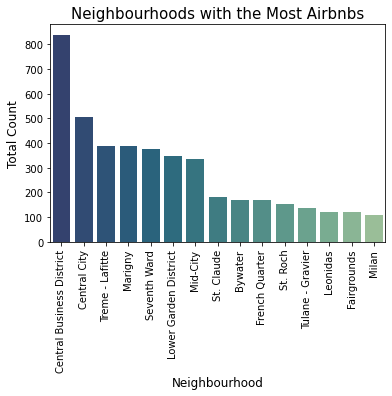

In [56]:
# view neighborhood data by count
sns.countplot(data=regression, x='neighbourhood_cleansed', palette='crest_r',
              order=regression.neighbourhood_cleansed.value_counts().iloc[:15].index)
plt.xticks(rotation=90)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Neighbourhoods with the Most Airbnbs', fontsize=15)
plt.show()

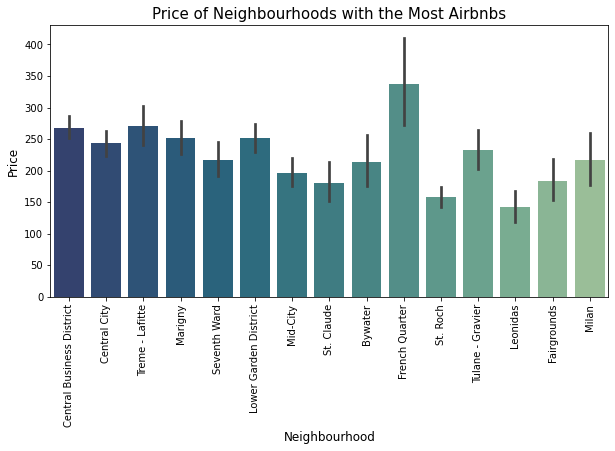

In [57]:
# view average price of the neighbourhoods with the most airbnbs
plt.figure(figsize=(10,5))
sns.barplot(x="neighbourhood_cleansed", y="price", data=regression,palette='crest_r',
            order=regression.neighbourhood_cleansed.value_counts().iloc[:15].index)
plt.xticks(rotation=90)
plt.xlabel('Neighbourhood', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Price of Neighbourhoods with the Most Airbnbs', fontsize=15)
plt.show()

I choose to look at the neighbourhoods with the most airbnbs since there is likely a reason why investors choose these areas, such as city rules, tourist attractions, or good house prices for the return 

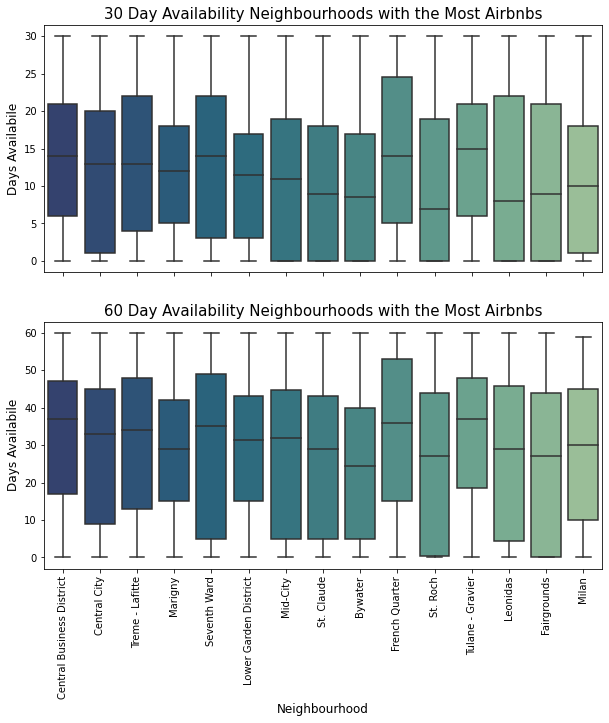

In [58]:
# Plot availability for 30 & 60 days for neighbourhoods with the most airbnbs
fig, axs = plt.subplots(nrows=2,sharex=True, figsize=(10,10))

#Plot availability_30 days
sns.boxplot(x="neighbourhood_cleansed", y="availability_30", data=regression,palette='crest_r',
            order=regression.neighbourhood_cleansed.value_counts().iloc[:15].index, ax=axs[0])
plt.xticks(rotation=90)
ax=axs[0].set_xlabel('', fontsize=12)
ax=axs[0].set_ylabel('Days Availabile', fontsize=12)
ax=axs[0].set_title('30 Day Availability Neighbourhoods with the Most Airbnbs', fontsize=15)

# Plot availability_60 days
sns.boxplot(x="neighbourhood_cleansed", y="availability_60", data=regression,palette='crest_r',
            order=regression.neighbourhood_cleansed.value_counts().iloc[:15].index, ax=axs[1])
plt.xticks(rotation=90)
ax=axs[1].set_xlabel('Neighbourhood', fontsize=12)
ax=axs[1].set_ylabel('Days Availabile', fontsize=12)
ax=axs[1].set_title('60 Day Availability Neighbourhoods with the Most Airbnbs', fontsize=15)
plt.show()


plt.show()

It is important to look at the availability, 30 & 60 day is more telling than 365 days becuase according to Airbnb most people book 28 days before they travel. Having little availability at 30 or 60 days is a good sign that the Neighbourhood is highly sought after by tourist and good business for the Airbnb owners. 

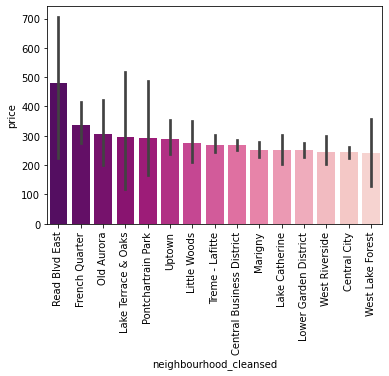

In [59]:
# View neighourhoods with the highest price
plot_order_price = regression.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).iloc[:15].index.values
color = sns.color_palette("RdPu_r", 18)
sns.barplot(data=regression, x='neighbourhood_cleansed', y='price', palette=color,
              order=plot_order_price)
plt.xticks(rotation=90)
plt.show()

Looking at the neighbourhoods with the highest priced Airbnbs gives us an indication of which towns might be the most disirable for both travelers & investors. 

In [60]:
# Make list of top neighbourhoods by count
top_count = regression.neighbourhood_cleansed.value_counts().iloc[:15].index
top_count

Index(['Central Business District', 'Central City', 'Treme - Lafitte',
       'Marigny', 'Seventh Ward', 'Lower Garden District', 'Mid-City',
       'St. Claude', 'Bywater', 'French Quarter', 'St. Roch',
       'Tulane - Gravier', 'Leonidas', 'Fairgrounds', 'Milan'],
      dtype='object')

In [61]:
# I want to print a list of over lapping neighbourhoods
bool(set(plot_order_price) & set(top_count))

True

In [62]:
any([item in plot_order_price for item in top_count])

True

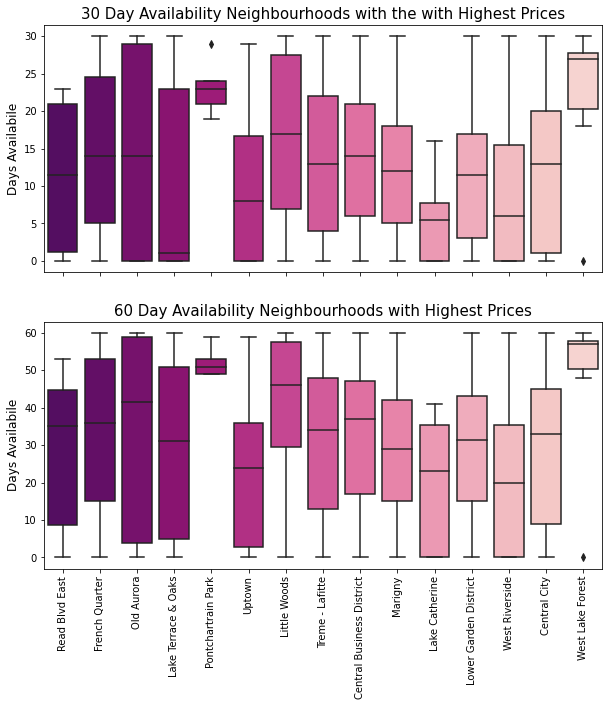

In [63]:
# View neighourhoods with the highest price
plot_order_price = regression.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).iloc[:15].index.values
color = sns.color_palette("RdPu_r", 18)

# Plot availability for 30 & 60 days for neighbourhoods with the most airbnbs
fig, axs = plt.subplots(nrows=2,sharex=True, figsize=(10,10))

sns.boxplot(data=regression, x='neighbourhood_cleansed', y='availability_30', palette=color,
              order=plot_order_price, ax=axs[0])
ax=axs[0].set_xlabel('', fontsize=12)
ax=axs[0].set_ylabel('Days Availabile', fontsize=12)
ax=axs[0].set_title('30 Day Availability Neighbourhoods with the with Highest Prices', fontsize=15)
plt.xticks(rotation=90)

# Plot availability for 30 & 60 days for neighbourhoods with the most airbnb
sns.boxplot(data=regression, x='neighbourhood_cleansed', y='availability_60', palette=color,
              order=plot_order_price, ax=axs[1])
ax=axs[1].set_xlabel('', fontsize=12)
ax=axs[1].set_ylabel('Days Availabile', fontsize=12)
ax=axs[1].set_title('60 Day Availability Neighbourhoods with Highest Prices', fontsize=15)
plt.xticks(rotation=90)

plt.show()

Again we look at availability since many investors believe this is the most important statistic for estimating profits. As a lower priced rental that is booked more can make much more than an expensive less booked rental in some situations. 

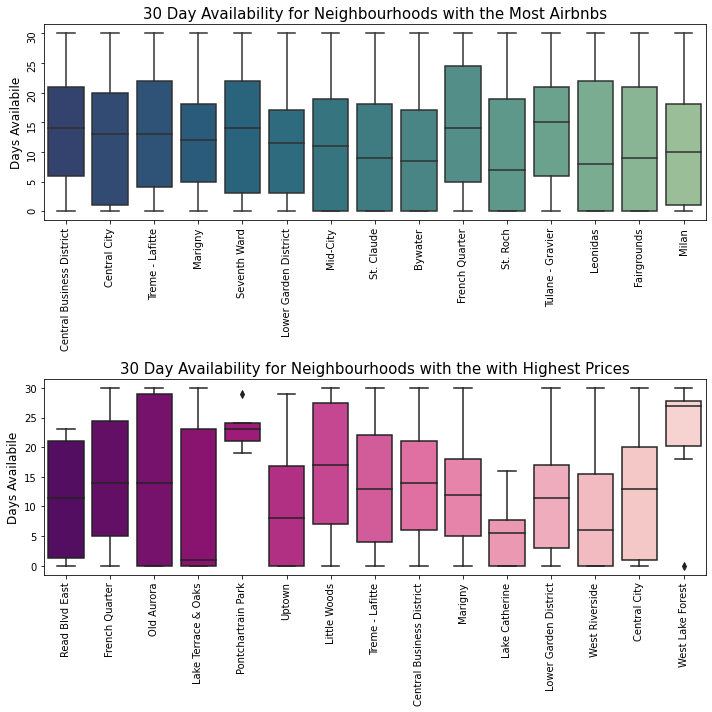

In [64]:
# Plot availability for 30 & 60 days for neighbourhoods with the most airbnbs
fig, axs = plt.subplots(nrows=2,sharex=False, figsize=(10,10))

#Plot availability_30 days
sns.boxplot(x="neighbourhood_cleansed", y="availability_30", data=regression,palette='crest_r',
            order=regression.neighbourhood_cleansed.value_counts().iloc[:15].index, ax=axs[0])
plt.xticks(rotation=90)
ax=axs[0].set_xlabel('', fontsize=12)
ax=axs[0].set_ylabel('Days Availabile', fontsize=12)
ax=axs[0].set_title('30 Day Availability for Neighbourhoods with the Most Airbnbs', fontsize=15)
ax=axs[0].tick_params(labelrotation=90)

# Plot availability_60 days
sns.boxplot(data=regression, x='neighbourhood_cleansed', y='availability_30', palette=color,
              order=plot_order_price, ax=axs[1])
ax=axs[1].set_xlabel('', fontsize=12)
ax=axs[1].set_ylabel('Days Availabile', fontsize=12)
ax=axs[1].set_title('30 Day Availability for Neighbourhoods with the with Highest Prices', fontsize=15)
plt.xticks(rotation=90)

fig.tight_layout()
plt.show()

Visualizing the difference between the most common neighbourhoods and the highest priced neighbourhoods gives a better understanding of the overall market. 

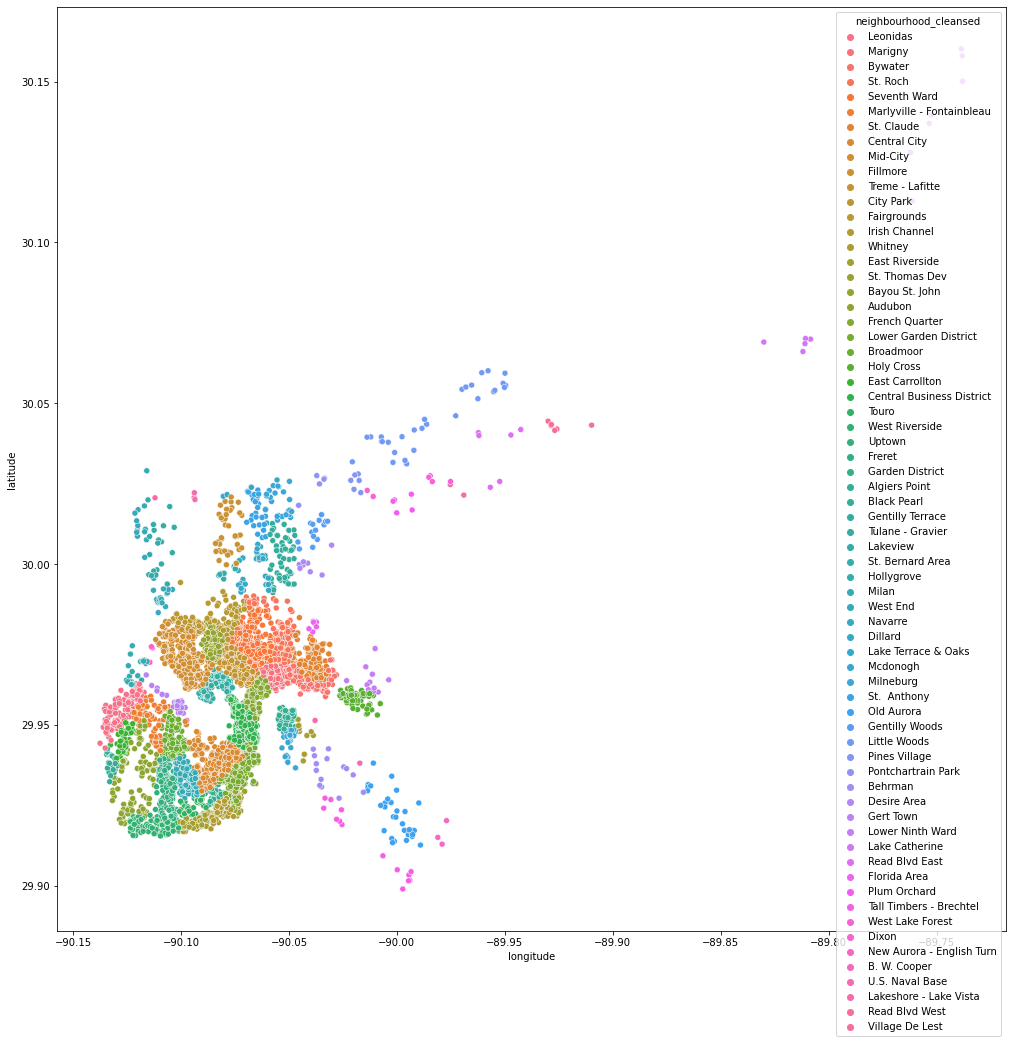

In [65]:
# plot all the airbnbs
plt.figure(figsize=(17,17))
sns.scatterplot(x = vis_location.longitude, y=vis_location.latitude,hue=vis_location.neighbourhood_cleansed)
plt.ioff()

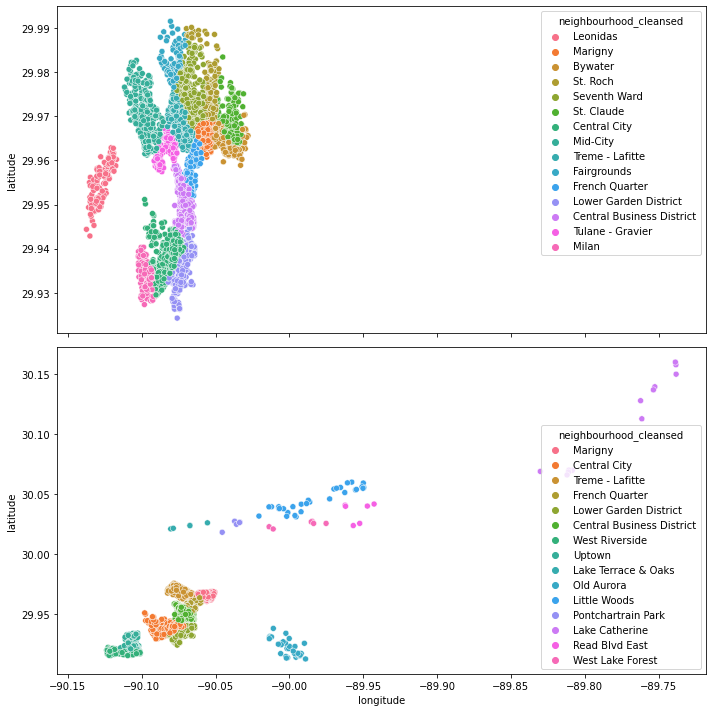

<Figure size 720x720 with 0 Axes>

In [66]:
# plot 
fig, axs = plt.subplots(nrows=2,sharex=True, figsize=(10,10))

plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude',
            hue='neighbourhood_cleansed', ax=axs[0],
            data=vis_location.loc[vis_location.neighbourhood_cleansed.isin(top_count)])

sns.scatterplot(x='longitude', y='latitude',
            hue='neighbourhood_cleansed', ax=axs[1],
            data=vis_location.loc[vis_location.neighbourhood_cleansed.isin(plot_order_price)])

fig.tight_layout()
plt.show()

In [67]:
#conda install geopandas did not work
#pip install geopandas

In [68]:
import geopandas as gpd
nb = 'neighbourhoods.geojson'
regions = gpd.read_file('Data/neighbourhoods.geojson')
regions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        72 non-null     object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             72 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.8+ KB


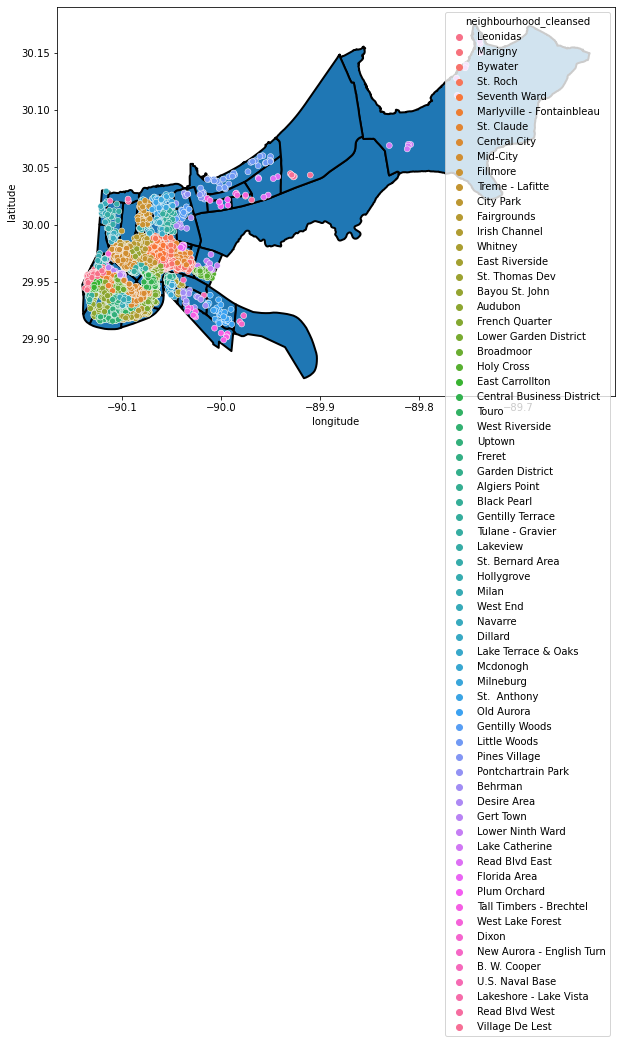

In [69]:
# plot all the airbnbs
ax = regions.plot(figsize=(10,10),
                edgecolor="black",
                linewidth=2)
sns.scatterplot(x = vis_location.longitude, y=vis_location.latitude,hue=vis_location.neighbourhood_cleansed)
plt.ioff()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

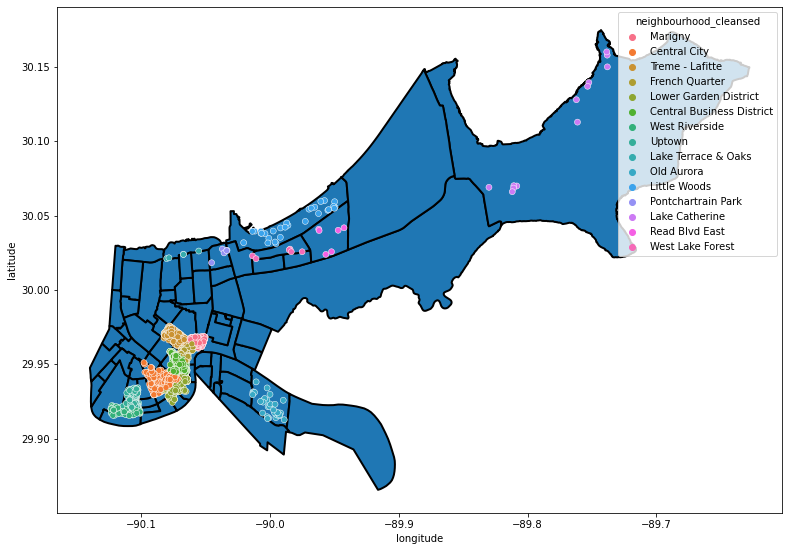

In [70]:
# plot the airbnbs 
ax = regions.plot(figsize=(13,13),
                edgecolor="black",
                linewidth=2)
sns.scatterplot(x='longitude', y='latitude',
            hue='neighbourhood_cleansed',
            data=vis_location.loc[vis_location.neighbourhood_cleansed.isin(plot_order_price)])

In [72]:
import folium
from folium.plugins import HeatMap

In [73]:
map = folium.Map(location=[vis_location.latitude.mean(), 
                           vis_location.longitude.mean()], 
                           zoom_start=14, control_scale=True)

In [74]:
for index, location_info in vis_location.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]]).add_to(map)

In [75]:
map_heat = folium.Map(location=[vis_location.latitude.mean(), 
                           vis_location.longitude.mean()], 
                           zoom_start=11, control_scale=True)

In [76]:
from folium.plugins import HeatMap
HeatMap(vis_location[['latitude','longitude']], radius=8,gradient={0.2:'blue',0.4:'lime',0.6:'orange',1.0:'darkred'}).add_to(map_heat)
display(map_heat)

In [71]:
# plot all the airbnbs
#ax = regions.plot(figsize=(13,13),
                #edgecolor="black",
                #linewidth=2, column='neighbourhood')
#regions.loc[regions[need] == 1].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

In [72]:
#need = ['Central Business District', 'Central City', 'Treme - Lafitte',
       #'Marigny', 'Seventh Ward', 'Lower Garden District', 'Mid-City',
       #'St. Claude', 'Bywater', 'French Quarter', 'St. Roch',
       #'Tulane - Gravier', 'Leonidas', 'Fairgrounds', 'Milan']

In [73]:
regions['neighbourhood'].head(15)

0               Garden District
1                  Little Woods
2                     Iberville
3                    Holy Cross
4      Viavant - Venetian Isles
5               U.S. Naval Base
6                 Algiers Point
7                       Whitney
8                  B. W. Cooper
9                       Audubon
10                     Fillmore
11                   Old Aurora
12              East Carrollton
13               Bayou St. John
14    Central Business District
Name: neighbourhood, dtype: object

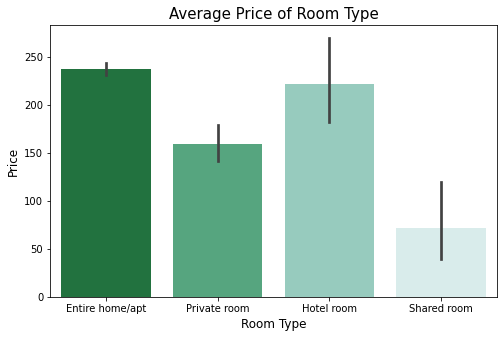

In [74]:
# Take a look at possible relationship between Price and Room Type
plt.figure(figsize=(8,5))
sns.barplot(x="room_type", y="price", data=regression, palette = 'BuGn_r')
#plt.xticks(rotation=90)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Average Price of Room Type', fontsize=15)
plt.show()

To get a better understanding of what type of property is more valued by travelers we see which has the highest average price. 

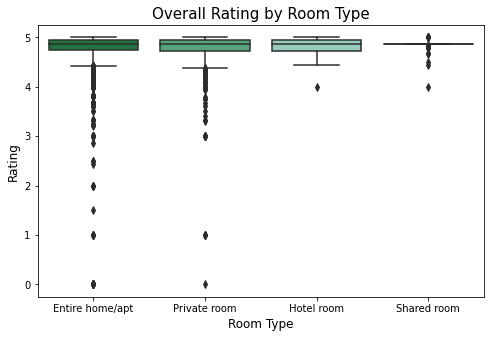

In [75]:
# Take a look at possible relationship between Price and Room Type
plt.figure(figsize=(8,5))
sns.boxplot(x="room_type", y="review_scores_rating", data=regression, palette = 'BuGn_r')
#plt.xticks(rotation=90)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.title('Overall Rating by Room Type', fontsize=15)
plt.show()

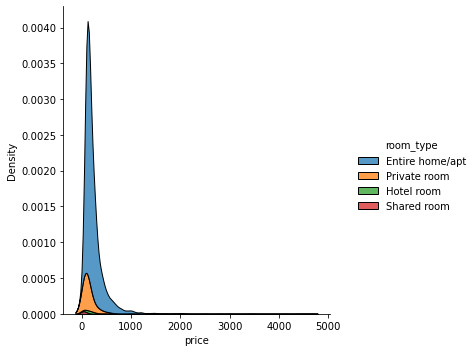

In [76]:
sns.displot(regression, x="price", hue="room_type", fill=True, multiple="stack",  kind="kde")

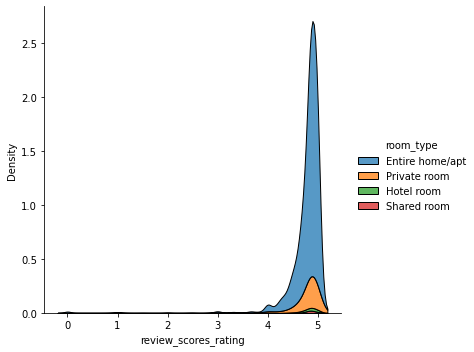

In [77]:
sns.displot(regression, x="review_scores_rating", hue="room_type", fill=True, multiple="stack",  kind="kde")

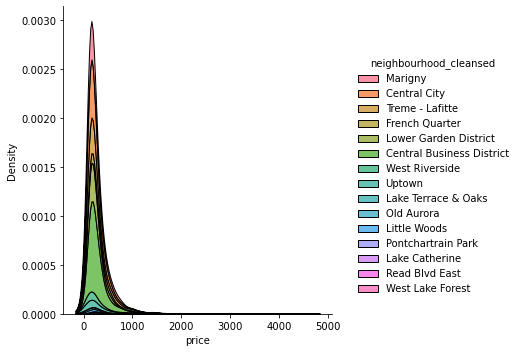

In [78]:
sns.displot(data=regression.loc[regression.neighbourhood_cleansed.isin(plot_order_price)], x="price", hue="neighbourhood_cleansed", fill=True, multiple="stack",  kind="kde")

### Data Visualization

Our Exploratory Analysis and Visualizations give us our first look at relationships and possible future complications we might see in out modeling. Overall we saw that price has a possible relationship with many of the columns such as `room_type`, `neighbourhood_cleansed`, and `30_Availability`. When we get to the modeling portion of this analysis we will see how strong this relationship are and find any other relationships among the columns that were not visualized. 
We also saw some outliers in some of our visualization.

### Exploratory Analysis
Further exploratory analysis will give us a better look at outliers, multicollinary, normality, and homoscedasticity

In [79]:
regression.rename(columns = {'bathrooms_text': 'bathrooms', 'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

### Before we remove outliers and encode the data we will split the data into test and training sets

In [80]:
from sklearn.model_selection import train_test_split
#y = regression['price'].copy()
#X = regression.drop('price',axis=1).copy()

#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
#X_train.shape,X_test.shape

In [81]:
# make df with both training sets so price can be plotted still
#Xy_train = X_train.join(y_train)

In [82]:
#y_train_df = y_train.to_frame()

In [83]:
df_train, df_test = train_test_split(regression,random_state=42)
df_train.shape,df_test.shape

((4515, 24), (1506, 24))

### Before outliers are removed we should run through some basic filter methods to make sure that we do not have constant or duplicated features
Even though this dataset doesnt have a ton of different features, it still is good practice to check for constant features. These are features that show a high prentage of the same value & they should be removed because in esence they are the same.

In [84]:
from sklearn.feature_selection import VarianceThreshold

In [85]:
# check for quasi constant numerical variables
num_cols = ['bedrooms', 'beds',
       'maximum_nights', 'availability_30',
       'availability_365', 'number_of_reviews',
       'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']

thresh = VarianceThreshold(threshold=0.01)  

thresh.fit(df_train[num_cols])

VarianceThreshold(threshold=0.01)

In [86]:
# double check that our variables are stored
sum(thresh.get_support())

12

In [87]:
# let's print the number of quasi-constant features & we see that there are no numerical columns that are quasi_constant
quasi_constant = df_train[num_cols].columns[~thresh.get_support()]

len(quasi_constant)

0

In [88]:
# create an empty list
cat_cols = ['host_is_superhost', 'neighbourhood', 'property_type', 'room_type','instant_bookable']
train_cat = df_train[cat_cols]

quasi_constant_var = []

# iterate over every feature
for var in train_cat.columns:

    # find predominant value for each variable
    predominant = train_cat[var].value_counts(
        normalize=True).sort_values(ascending=False).values[0]

    # 99% of values are the same
    if predominant > 0.998:

        # make list if yest
        quasi_constant_feat.append(var)

len(quasi_constant_var)

0

### Only remove outliers from training set


In [89]:
# Make funtions to easily view distribution
def plot_distribution(df_train, col='price'):
    # Plot displot + mean and mean
    median = df_train[col].median()
    mean = df_train[col].mean()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(data=df_train[col], ax=ax)

    ax.set_title(F"Distribution of {col}")
    ax.axvline(median,label=f'median={median:,}',color='black')
    ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax.legend()

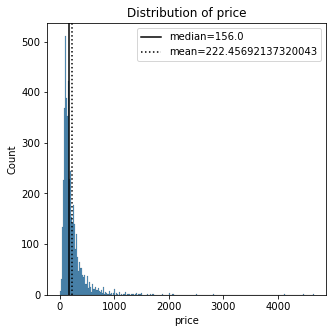

In [90]:
# Price is skewed and the outliers are impacting the normalacy
plot_distribution(df_train, 'price')

In [91]:
# Make a function to find outlier using IQR method
# I want to keep as much data as possible so I am making my q1 small and my q3 large
from scipy import stats
def find_outliers_IQR(df_train):
    q1 = df_train.quantile(0.15)
    q3 = df_train.quantile(0.85)
    thresh = 1.5*(q3-q1)
    idx_outliers =(df_train < (q1-thresh)) | (df_train > (q3+thresh))
    return idx_outliers

In [92]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course

def diagnostic_plots(df_train, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    median = df_train[variable].median()
    mean = df_train[variable].mean()
    sns.histplot(df_train[variable], bins=30)
    #plt.title('Histogram')
    
    plt.title(F"Distribution of {variable}")
    plt.axvline(median,label=f'median={median:,}',color='black')
    plt.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    plt.legend()

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df_train[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df_train[variable])
    plt.title('Boxplot')

    plt.show()

In [93]:
price_outliers_IQR = find_outliers_IQR(df_train['price'])
price_outliers_IQR.sum()

141

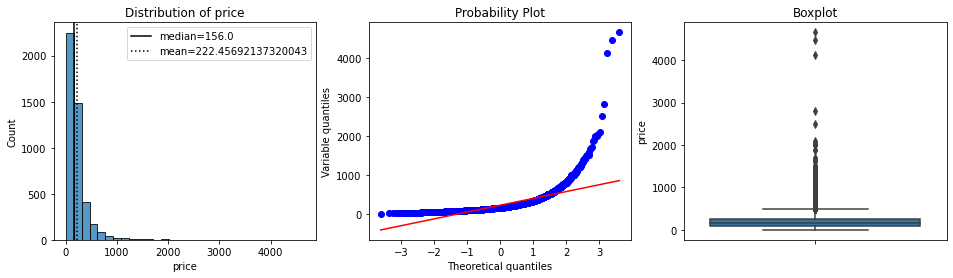

In [94]:
# Look at plots before removing outliers
diagnostic_plots(df_train, 'price')

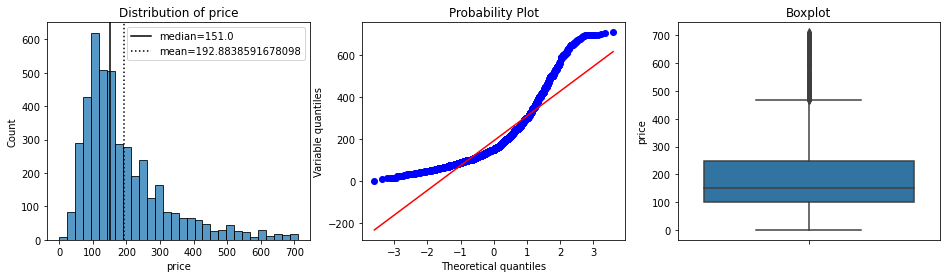

In [95]:
# See how removing these outliers would change the distribution
df_train = df_train[~price_outliers_IQR].copy()

# Remove outliers for visualization df 
diagnostic_plots(df_train, 'price')

All three plots indicate that removing the outliers have helped with normality 

In [96]:
df_train['price'].describe()

count    4374.000000
mean      192.883859
std       127.948622
min         0.000000
25%       102.000000
50%       151.000000
75%       248.000000
max       711.000000
Name: price, dtype: float64

In [97]:
df_train.loc[df_train['price'] == 0]

,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
4228,t,Marigny,Room in boutique hotel,Hotel room,4,1 bath,1.0,1.0,0.0,1,...,0,15,5.0,5.0,4.87,4.87,5.0,4.87,4.93,f


In [98]:
# row with no price
df_train.drop(4228, axis=0, inplace=True)

In [99]:
df_test.loc[df_test['price'] == 0]

,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
4280,f,Mid-City,Room in hotel,Hotel room,8,1 bath,1.0,1.0,0.0,1,...,0,0,4.86,4.91,4.88,4.96,4.95,4.87,4.83,f


In [100]:
df_test.drop(4280, axis=0, inplace=True)

In [101]:
# See about removing bedroom outliers
bedrooms_outliers_IQR = find_outliers_IQR(df_train['bedrooms'])
bedrooms_outliers_IQR.sum()

18

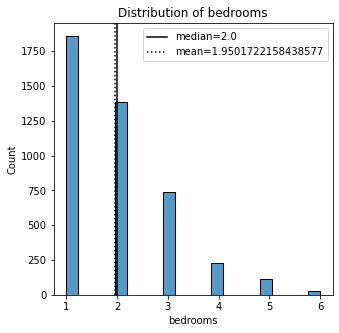

In [102]:
# find top outliers
find_bedrooms = df_train[~bedrooms_outliers_IQR]
plot_distribution(find_bedrooms, 'bedrooms')

In [103]:
# See about removing bedroom outliers
beds_outliers_IQR = find_outliers_IQR(df_train['beds'])
beds_outliers_IQR.sum()

56

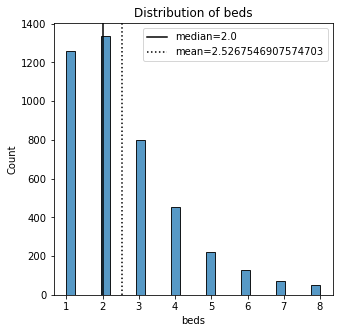

In [104]:
# Remove top outliers
find_beds = df_train[~beds_outliers_IQR]
plot_distribution(find_beds, 'beds')

In [105]:
review_cols = ['review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']

def diagnostic_reviews(df_train, review_cols):
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True)

    for col, ax in zip(review_cols, axes.flatten()):
        ax.hist(df_train[col], bins='auto')
        ax.set_title(col)
    
        median = df_train[col].median()
        mean = df_train[col].mean()
    
        ax.set_title(F"Distribution of {col}")
        ax.axvline(median,label=f'median={median:,}',color='black')
        ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
        ax.legend()
 
    fig.tight_layout()

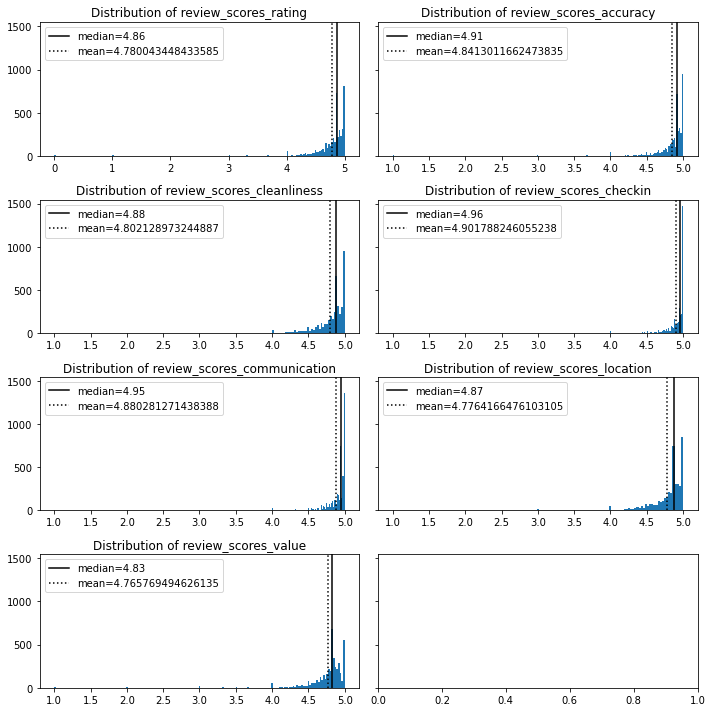

In [106]:
diagnostic_reviews(df_train, review_cols)

In [107]:
# See about removing bedroom outliers
review_scores_rating_outliers_IQR = find_outliers_IQR(df_train['review_scores_rating'])
review_scores_rating_outliers_IQR.sum()

113

In [108]:
review_scores_location_outliers_IQR = find_outliers_IQR(df_train['review_scores_location'])
review_scores_location_outliers_IQR.sum()

72

In [109]:
review_scores_communication_outliers_IQR = find_outliers_IQR(df_train['review_scores_communication'])
review_scores_communication_outliers_IQR.sum()

145

In [110]:
review_scores_checkin_outliers_IQR = find_outliers_IQR(df_train['review_scores_checkin'])
review_scores_checkin_outliers_IQR.sum()

191

In [111]:
review_scores_cleanliness_outliers_IQR = find_outliers_IQR(df_train['review_scores_cleanliness'])
review_scores_cleanliness_outliers_IQR.sum()

99

In [112]:
review_scores_accuracy_outliers_IQR = find_outliers_IQR(df_train['review_scores_accuracy'])
review_scores_accuracy_outliers_IQR.sum()

130

In [113]:
review_scores_value_outliers_IQR = find_outliers_IQR(df_train['review_scores_value'])
review_scores_value_outliers_IQR.sum()

122

In [114]:
min_night_outliers_IQR = find_outliers_IQR(df_train['minimum_nights'])
min_night_outliers_IQR.sum()

29

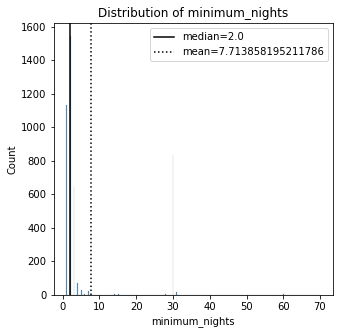

In [115]:
# Remove top outliers
find_min_night = df_train[~min_night_outliers_IQR]
plot_distribution(find_min_night, 'minimum_nights')

In [116]:
max_night_outliers_IQR = find_outliers_IQR(df_train['maximum_nights'])
max_night_outliers_IQR.sum()

1

In [117]:
# I dont want to remove more outliers than I need to. Instead I am going to change 0 reivews to 1 review.
# If the lowest value is 1, I can than use a log transformation on this skewed variable, if I keep the min at 0 I cannot
number_reviews_IQR = find_outliers_IQR(df_train['number_of_reviews'])
number_reviews_IQR.sum()

92

In [118]:
# Again we want to remove as few rows as possible so for bathrooms we will make a 5 or more columns instead
df_train.loc[df_train['bathrooms'].str.contains("1|0"),'bathrooms'] = '1 bath'
df_train.loc[df_train['bathrooms'].str.contains("2"),'bathrooms'] = '2 baths'
df_train.loc[df_train['bathrooms'].str.contains("3"),'bathrooms'] = '3 baths'
df_train.loc[df_train['bathrooms'].str.contains("4"),'bathrooms'] = '4 baths'
df_train.loc[df_train['bathrooms'].str.contains("5|6|7|8|9"),'bathrooms'] = '5 or more baths'

#same for test set
df_test.loc[df_test['bathrooms'].str.contains("1|0"),'bathrooms'] = '1 bath'
df_test.loc[df_test['bathrooms'].str.contains("2"),'bathrooms'] = '2 baths'
df_test.loc[df_test['bathrooms'].str.contains("3"),'bathrooms'] = '3 baths'
df_test.loc[df_test['bathrooms'].str.contains("4"),'bathrooms'] = '4 baths'
df_test.loc[df_test['bathrooms'].str.contains("5|6|7|8|9"),'bathrooms'] = '5 or more baths'

df_train['bathrooms'].value_counts()

1 bath             2805
2 baths            1293
3 baths             196
4 baths              62
5 or more baths      17
Name: bathrooms, dtype: int64

In [119]:
# let's trimm the dataset
rating_outliers = (review_scores_rating_outliers_IQR | review_scores_value_outliers_IQR | 
                              review_scores_checkin_outliers_IQR | review_scores_communication_outliers_IQR |
                              review_scores_location_outliers_IQR | review_scores_accuracy_outliers_IQR |
                              review_scores_cleanliness_outliers_IQR | min_night_outliers_IQR | max_night_outliers_IQR|
                              beds_outliers_IQR | bedrooms_outliers_IQR | number_reviews_IQR)


In [120]:
# make df_clean 
df_train = df_train[~rating_outliers].copy()

df_train started with 4515 rows and ended with 3251 rows

In [121]:
review_num = ['price', 'accommodates', 'maximum_nights', 'minimum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews' ]

def diagnostic_reviews_num(df_train, review_num):
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=False)

    for col, ax in zip(review_num, axes.flatten()):
        ax.hist(df_train[col], bins='auto')
        ax.set_title(col)
    
        median = df_train[col].median()
        mean = df_train[col].mean()
    
        ax.set_title(F"Distribution of {col}")
        ax.axvline(median,label=f'median={median:,}',color='black')
        ax.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
        ax.legend()
 
    fig.tight_layout()

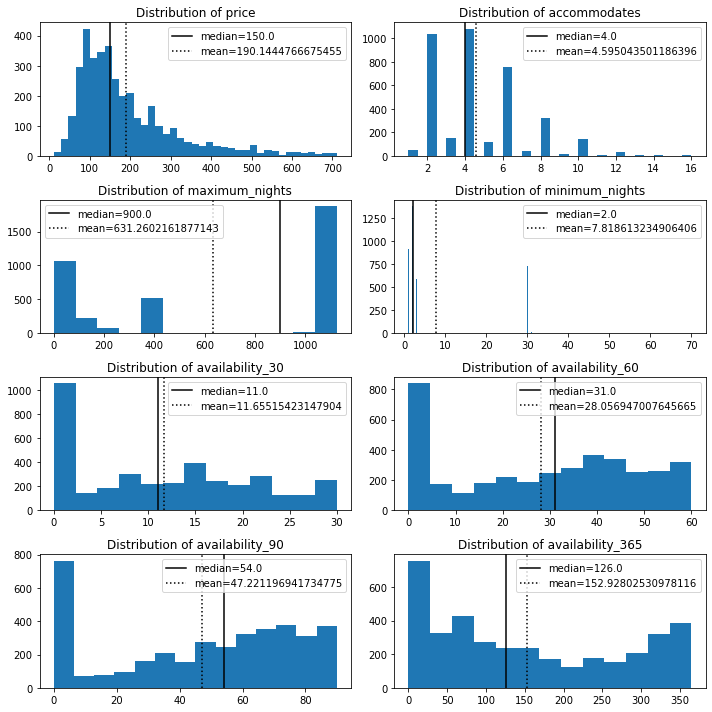

In [122]:
diagnostic_reviews_num(df_train, review_num)

In [123]:
df_train['minimum_nights'].value_counts()

2     1385
1      913
30     736
3      592
4       61
5       28
7       23
31      15
6        8
60       8
28       7
15       4
14       3
10       2
32       2
29       1
70       1
12       1
18       1
9        1
59       1
Name: minimum_nights, dtype: int64

In [124]:
df_train.columns

Index(['host_is_superhost', 'neighbourhood', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable'],
      dtype='object')

In [125]:
# ordinal encoder
ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['host_is_superhost', 'bathrooms', 'beds', 'bedrooms'])

ordinal_enc.fit(df_train)
#ordinal_enc.fit(df_test_encoded)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['host_is_superhost', 'bathrooms', 'beds', 'bedrooms'])

In [126]:
ordinal_enc.encoder_dict_

{'host_is_superhost': {'t': 0, 'f': 1},
 'bathrooms': {'1 bath': 0,
  '2 baths': 1,
  '3 baths': 2,
  '4 baths': 3,
  '5 or more baths': 4},
 'beds': {1.0: 0, 3.0: 1, 2.0: 2, 4.0: 3, 6.0: 4, 5.0: 5, 8.0: 6, 7.0: 7},
 'bedrooms': {1.0: 0, 2.0: 1, 4.0: 2, 3.0: 3, 5.0: 4, 6.0: 5}}

In [127]:
df_train_ord = ordinal_enc.transform(df_train)
df_test_ord = ordinal_enc.transform(df_test)

/Users/rachelfein/opt/anaconda3/envs/predictive-env/lib/python3.9/site-packages/feature_engine/encoding/base_encoder.py:238: UserWarning: During the encoding, NaN values were introduced in the feature(s) beds, bedrooms.
  warnings.warn(


In [128]:
df_test_ord.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1505 entries, 5113 to 4410
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            1505 non-null   int64  
 1   neighbourhood                1505 non-null   object 
 2   property_type                1505 non-null   object 
 3   room_type                    1505 non-null   object 
 4   accommodates                 1505 non-null   int64  
 5   bathrooms                    1505 non-null   int64  
 6   bedrooms                     1497 non-null   float64
 7   beds                         1468 non-null   float64
 8   price                        1505 non-null   float64
 9   minimum_nights               1505 non-null   int64  
 10  maximum_nights               1505 non-null   int64  
 11  availability_30              1505 non-null   int64  
 12  availability_60              1505 non-null   int64  
 13  availability_90

In [129]:
# Since we did not remove outliers from test set when we encoded those outliers became NaNs
df_test_ord['beds'].fillna(7, inplace=True)
df_test_ord['bedrooms'].fillna(5, inplace=True)
df_test_ord['bathrooms'].fillna(2, inplace=True)

In [130]:
#df_train_ord['minimum_nights'] = df_train_ord['minimum_nights'].astype(object)
#df_test_ord['minimum_nights'] = df_test_ord['minimum_nights'].astype(object)

In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 2025 to 860
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_is_superhost            3793 non-null   object 
 1   neighbourhood                3793 non-null   object 
 2   property_type                3793 non-null   object 
 3   room_type                    3793 non-null   object 
 4   accommodates                 3793 non-null   int64  
 5   bathrooms                    3793 non-null   object 
 6   bedrooms                     3793 non-null   object 
 7   beds                         3793 non-null   object 
 8   price                        3793 non-null   float64
 9   minimum_nights               3793 non-null   int64  
 10  maximum_nights               3793 non-null   int64  
 11  availability_30              3793 non-null   int64  
 12  availability_60              3793 non-null   int64  
 13  availability_90 

In [132]:
ohe_enc = fe_OneHotEncoder(variables=['neighbourhood', 'property_type',
                                      'room_type', 'instant_bookable'], drop_last=True)

ohe_enc.fit(df_train_ord)

OneHotEncoder(drop_last=True,
              variables=['neighbourhood', 'property_type', 'room_type',
                         'instant_bookable'])

In [133]:
import warnings
warnings.filterwarnings('ignore')

df_train_encoded = ohe_enc.transform(df_train_ord)

In [134]:
warnings.filterwarnings('ignore')

df_test_encoded = ohe_enc.transform(df_test_ord)

In [135]:
# Make sure train set looks right
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 2025 to 860
Columns: 134 entries, host_is_superhost to instant_bookable_t
dtypes: float64(8), int64(126)
memory usage: 3.9 MB


In [136]:
# Make sure test set looks right
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1505 entries, 5113 to 4410
Columns: 134 entries, host_is_superhost to instant_bookable_t
dtypes: float64(10), int64(124)
memory usage: 1.6 MB


In [137]:
df_train.columns

Index(['host_is_superhost', 'neighbourhood', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable'],
      dtype='object')

In [138]:
# see which predictors have high correlation which each other
correlation = df_train_encoded.corr().abs().stack().reset_index().sort_values(0, ascending=False)

correlation['pairs'] = list(zip(correlation.level_0, correlation.level_1))

correlation.set_index(['pairs'], inplace = True)

correlation.drop(columns=['level_1', 'level_0'], inplace = True)

correlation.columns = ['corr_coef']

correlation[(correlation.corr_coef>.75) & (correlation.corr_coef<1)]

,corr_coef
pairs,
"(availability_90, availability_60)",0.951020
"(availability_60, availability_90)",0.951020
"(room_type_Entire home/apt, room_type_Private room)",0.932969
"(room_type_Private room, room_type_Entire home/apt)",0.932969
"(availability_60, availability_30)",0.921863
"(availability_30, availability_60)",0.921863
"(availability_30, availability_90)",0.840949
"(availability_90, availability_30)",0.840949
"(accommodates, bedrooms)",0.801922


When two columns have a high correlation it will hurt the models performance. To help solve the issue of multicollinearity we will elimnate one column from each highly corrilate pair. In this case I will remove `availability_90`, `property_type_Shared room in residential home`, `availability_60` and `review_scores_accuracy`

In [139]:
# Remove one column from each highly correlated pair
df_train_encoded.drop(['availability_90','room_type_Entire home/apt', 'review_scores_accuracy', 'accommodates',
                      'availability_60'], axis=1, inplace=True)

In [140]:
df_test_encoded.drop(['availability_90','room_type_Entire home/apt', 'review_scores_accuracy', 'accommodates',
                      'availability_60'], axis=1, inplace=True)

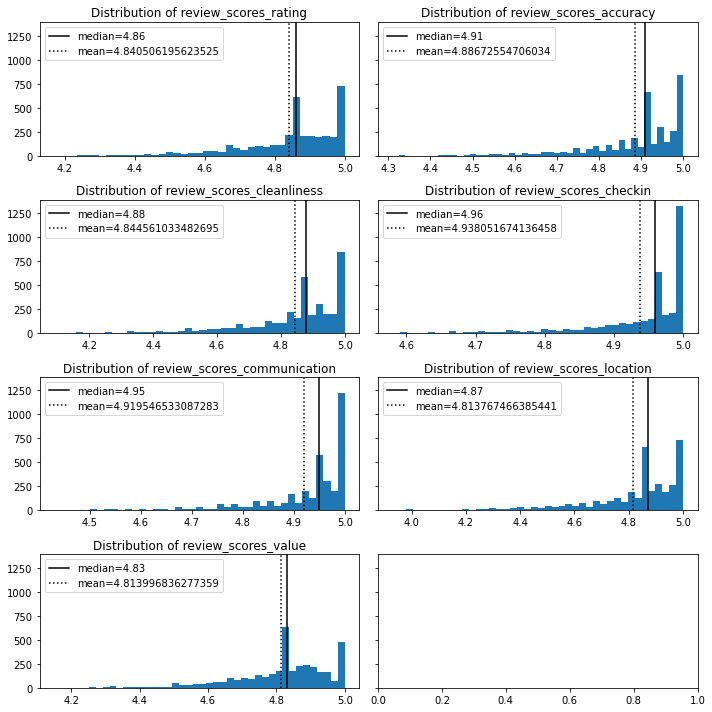

In [141]:
diagnostic_reviews(df_train, review_cols)

In [142]:
# take a look at how skewed the continious features are

def print_skewness(df):
    print(f'''The skewness of the cleanliness score is:\
    {df["review_scores_cleanliness"].skew():.2f}''')

    print(f'''The skewness of the overall rating is:\
     {df["review_scores_rating"].skew():.2f}''')

    print(f'''The skewness of the value score is: \
     {df["review_scores_value"].skew():.2f}''')

    print(f'''The skewness of the communication score is: \
     {df["review_scores_communication"].skew():.2f}''')

    print(f'''The skewness of the location score is: \
     {df["review_scores_location"].skew():.2f}''')

    print(f'''The skewness of the checkin score is: \
     {df["review_scores_checkin"].skew():.2f}''')

    print(f'''The skewness of the number of reviews is: \
     {df["number_of_reviews"].skew():.2f}''')

    print(f'''The skewness of the price is: \
     {df["price"].skew():.2f}''')

In [143]:
print_skewness(df_train)

The skewness of the cleanliness score is:    -1.64
The skewness of the overall rating is:     -1.40
The skewness of the value score is:      -1.15
The skewness of the communication score is:      -1.93
The skewness of the location score is:      -1.70
The skewness of the checkin score is:      -1.88
The skewness of the number of reviews is:      1.45
The skewness of the price is:      1.61


We have removed the outliers for the rating columns yet the variables are still skewed except `review_scores_value`. Since I plan on running a linear regression model as one of my model types to test I am going to log transform the skewed data. 

In [144]:
# To do log transformation there cannot be any zero values. I will change all listings that have 0 reviews to having
# 1 review

df_train_encoded.loc[(df_train_encoded['number_of_reviews'] == 0), 'number_of_reviews'] = 1
df_test_encoded.loc[(df_test_encoded['number_of_reviews'] == 0), 'number_of_reviews'] = 1

df_train_encoded.loc[(df_train_encoded['review_scores_rating'] == 0), 'review_scores_rating'] = 1
df_test_encoded.loc[(df_test_encoded['review_scores_rating'] == 0), 'review_scores_rating'] = 1

df_train_encoded['number_of_reviews'].describe()

count    3793.000000
mean       56.502768
std        62.149333
min         1.000000
25%         8.000000
50%        35.000000
75%        84.000000
max       294.000000
Name: number_of_reviews, dtype: float64

In [145]:
skewed_cols = ['number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin','review_scores_communication',
       'review_scores_location', 'price']

train_log = df_train_encoded.copy()
test_log = df_test_encoded.copy()

train_log[skewed_cols] = np.log(df_train_encoded[skewed_cols])
test_log[skewed_cols] = np.log(df_test_encoded[skewed_cols])


In [146]:
print_skewness(train_log)

The skewness of the cleanliness score is:    -1.77
The skewness of the overall rating is:     -1.51
The skewness of the value score is:      -1.15
The skewness of the communication score is:      -2.00
The skewness of the location score is:      -1.84
The skewness of the checkin score is:      -1.93
The skewness of the number of reviews is:      -0.64
The skewness of the price is:      0.04


In [147]:
# remove the target variable from df_train_encoded
target = 'price'

y_train = df_train_encoded[target].copy()
X_train = df_train_encoded.drop(target, axis=1).copy()
y_test = df_test_encoded[target].copy()
X_test = df_test_encoded.drop(target, axis=1).copy()

In [148]:
skewed_cols_X = ['number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin','review_scores_communication',
       'review_scores_location']


In [149]:
y_train = y_train.to_frame()

In [150]:
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

X_train_bc = X_train.copy()
y_train_bc = y_train.copy()
X_test_bc = X_test.copy()

# create the transformer
transformer = PowerTransformer(method='box-cox', standardize=False)

# create the transformer for y
transformer_y = PowerTransformer(method='box-cox', standardize=False)

# fit the y_transformer on y_train and transform y_train only
transformer_y.fit_transform(y_train_bc)

# fit the x transformer on X_train
transformer.fit(X_train_bc[skewed_cols_X])

# transform the X_training data 
X_train_bc[skewed_cols_X] = transformer.transform(X_train_bc[skewed_cols_X])

# transform the X_test data
X_test_bc[skewed_cols_X] = transformer.transform(X_test_bc[skewed_cols_X])

In [151]:
# setup standardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [152]:
# fit on x_train
scaler_x.fit(X_train_bc)
# fit on y_train
scaler_y.fit(y_train_bc)

# transform X_train
X_train_scaled = scaler_x.transform(X_train_bc)
# transofrm X_test
X_test_scaled = scaler_x.transform(X_test_bc)


# transform y_train only 
y_train_scaled = scaler_y.transform(y_train_bc)


In [153]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_bc.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_bc.columns)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=y_train_bc.columns)
np.round(X_train_scaled.describe(), 1)

,host_is_superhost,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,...,property_type_Shared room in tiny house,property_type_Barn,property_type_Room in serviced apartment,property_type_Farm stay,property_type_Room in resort,property_type_Entire home/apt,property_type_Shared room in condominium (condo),room_type_Private room,room_type_Shared room,instant_bookable_t
count,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,...,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0,3793.0
mean,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.1,-0.7,-0.9,-1.1,-0.6,-1.3,-1.2,-1.2,-1.6,-2.2,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,-1.0
25%,-1.1,-0.7,-0.9,-1.1,-0.5,-1.1,-1.2,-0.9,-0.8,-0.7,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,-1.0
50%,1.0,-0.7,-0.0,0.2,-0.5,0.5,-0.1,-0.2,0.1,-0.1,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,1.0
75%,1.0,0.9,0.8,0.2,-0.4,1.0,0.8,1.0,0.8,0.8,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4,-0.1,1.0
max,1.0,5.5,3.3,3.3,5.4,1.0,1.9,1.7,2.0,1.4,...,43.5,61.6,61.6,43.5,61.6,61.6,61.6,2.6,12.8,1.0


## End of preprocessing notebook, next notebook is modeling

In [154]:
X_train_scaled.to_csv('Data/X_train_ol.csv', index=False)
X_test_scaled.to_csv('Data/X_test_ol.csv', index=False)
y_train_scaled.to_csv('Data/y_train_ol.csv', index=False)
y_test.to_csv('Data/y_test_ol.csv', index=False)